*This notebook plots the lastmile latency for DSL, CABLE and FIBRE probes separately for each service provider in RIPE Atlas.*
- - - 

In [59]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [60]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [61]:
import sqlite3
import pandas as pd
import matplotlib.gridspec as gridspec

In [62]:
DB_LOCATION = 'lastmile.db'

In [63]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [64]:
con = sqlite3.connect(DB_LOCATION)

In [65]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , s.asn
                        , s.asn_holder_name
                        , s.asn_access_type                
                        , ext.access_type_technology
                        , agg.h1_median || ';' || agg.h2_median as h1h2

               FROM   %s                             as  agg
                    , %s                             as  api
                    , %s                             as  s               
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn_v4                   =  s.asn

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1

               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [66]:
df_ra.count()

probeid                   134724
timestamp                 134724
asn                       134724
asn_holder_name           134724
asn_access_type           134724
access_type_technology     43963
h1h2                      130006
dtype: int64

In [67]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,asn_access_type,access_type_technology,h1h2
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.429;20.49
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.431;17.7
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.438;17.776
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.478;17.577
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.422;17.526


In [68]:
df_ra = df_ra.dropna(subset = ['h1h2'])

In [69]:
df_ra.count()

probeid                   130006
timestamp                 130006
asn                       130006
asn_holder_name           130006
asn_access_type           130006
access_type_technology     40625
h1h2                      130006
dtype: int64

In [70]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,asn_access_type,access_type_technology,h1h2
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.429;20.49
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.431;17.7
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.438;17.776
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.478;17.577
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.422;17.526


In [71]:
df_ra.count()

probeid                   130006
timestamp                 130006
asn                       130006
asn_holder_name           130006
asn_access_type           130006
access_type_technology     40625
h1h2                      130006
dtype: int64

In [72]:
def calculate_lastmile_latency(h1h2):
    try: h1,h2 = h1h2.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: lastmile = float(h2) - float(h1)
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return lastmile

In [73]:
df_ra['lastmile'] = df_ra['h1h2'].apply(calculate_lastmile_latency)

In [74]:
df_ra.head()

,probeid,timestamp,asn,asn_holder_name,asn_access_type,access_type_technology,h1h2,lastmile
0,10006,1406548034,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.429;20.49,20.061
1,10006,1406562432,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.431;17.7,17.269
2,10006,1406576835,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.438;17.776,17.338
3,10006,1406591230,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.478;17.577,17.099
4,10006,1406605631,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.422;17.526,17.104


In [75]:
df_ra.count()

probeid                   130006
timestamp                 130006
asn                       130006
asn_holder_name           130006
asn_access_type           130006
access_type_technology     40625
h1h2                      130006
lastmile                  130006
dtype: int64

In [76]:
df_ra_groupby = df_ra.groupby('probeid')
df_ra_agg = df_ra_groupby['lastmile'].agg(['median'])
df_ra_merged = pd.merge(df_ra, df_ra_agg, left_on='probeid', right_index=True)

del df_ra_merged['timestamp']
del df_ra_merged['h1h2']
del df_ra_merged['lastmile']

df_ra_merged = df_ra_merged.drop_duplicates()
df_ra_merged.rename(columns={'median': 'lastmile_median'}, inplace=True)

In [77]:
df_ra_merged = df_ra_merged.sort('lastmile_median')

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [78]:
df_ra_merged.count()

probeid                   691
asn                       691
asn_holder_name           691
asn_access_type           691
access_type_technology    221
lastmile_median           691
dtype: int64

In [79]:
df_ra_merged.head()

,probeid,asn,asn_holder_name,asn_access_type,access_type_technology,lastmile_median
71433,14682,13037,"ZEN-AS Zen Internet Ltd,GB",DSL,DSL,-83.901
81120,15389,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,-72.740
68553,14582,2856,"BT-UK-AS BT Public Internet Service,GB",DSL,None,-39.872
94226,16233,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,None,0.007
208,10007,7922,"COMCAST-7922 - Comcast Cable Communications, I...",CABLE,CABLE,0.049


In [80]:
def myfunc(x):
    count = 0
    manual = x['asn_access_type']; rdns = x['access_type_technology']
    
    chosen = None
    if manual is None and rdns is None: chosen = None
    elif manual is None and rdns is not None: chosen = rdns
    elif manual is not None and rdns is None: chosen = manual
    elif manual == rdns: chosen = rdns
    elif manual != rdns:
        if rdns == 'FIBRE': chosen = rdns    
        else: print(x['probeid']); count += 1
    else: print('wow!')   
        
    return chosen

df_ra_merged['chosen'] = df_ra_merged.apply(myfunc, axis=1)

10151


In [81]:
df_ra_merged[df_ra_merged.probeid == 10151]

,probeid,asn,asn_holder_name,asn_access_type,access_type_technology,lastmile_median,chosen
3261,10151,5089,"NTL Virgin Media Limited,GB",CABLE,DSL,30.4395,None


In [82]:
df_ra_merged.count()

probeid                   691
asn                       691
asn_holder_name           691
asn_access_type           691
access_type_technology    221
lastmile_median           691
chosen                    690
dtype: int64

In [83]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

df_ra_merged = df_ra_merged.apply(myfunc, axis=1)

In [84]:
del df_ra_merged['asn_access_type']
del df_ra_merged['access_type_technology']
del df_ra_merged['asn']
del df_ra_merged['asn_holder_name']

In [85]:
df_ra_merged.head()

,probeid,lastmile_median,chosen,nodename
71433,14682,-83.901,DSL,ZEN (AS13037)
81120,15389,-72.740,DSL,XS4ALL (AS3265)
68553,14582,-39.872,DSL,BT (AS2856)
94226,16233,0.007,DSL,XS4ALL (AS3265)
208,10007,0.049,CABLE,COMCAST (AS7922)


In [86]:
df_ra_merged['nodename'] = df_ra_merged['nodename'].apply(lambda node: node.split(' ')[0])

In [87]:
df_ra_merged = df_ra_merged.dropna()

In [88]:
df_ra_merged.count()

probeid            690
lastmile_median    690
chosen             690
nodename           690
dtype: int64

In [89]:
df_dsl   = df_ra_merged[df_ra_merged.chosen == 'DSL']
df_cable = df_ra_merged[df_ra_merged.chosen == 'CABLE']
df_fibre = df_ra_merged[df_ra_merged.chosen == 'FIBRE']

In [90]:
dsl_count   = df_dsl['probeid'].count()
cable_count = df_cable['probeid'].count()
fibre_count = df_fibre['probeid'].count()

print('dsl: %d'%(dsl_count))
print('cable: %d'%(cable_count))
print('fibre: %d'%(fibre_count))

print('total: %d'%(dsl_count + cable_count + fibre_count))

dsl: 429
cable: 225
fibre: 36
total: 690


In [91]:
df_dsl_groupby = df_dsl.groupby('nodename', )
df_cable_groupby = df_cable.groupby('nodename')
df_fibre_groupby = df_fibre.groupby('nodename')

In [92]:
def draw_cdf_step(df, nodename, index):
    
    if index >= 7: linestyle = 'dashed'
    else: linestyle = 'solid'
        
    n,bins,patches = \
    plt.hist (      df['lastmile_median'].values 
                  , normed=True
                  , cumulative=True
                  , histtype='step'
                  , label="%s (%d)"%(nodename, df['probeid'].count())          
                  , linewidth=7
                  , bins=df['probeid'].count()
                  , linestyle=(linestyle)
             );
    
    patches[0].set_xy(patches[0].get_xy()[:-1])

In [93]:
def start_plot():    
    #----- plt.style.use('ggplot')
    #color_list = plt.cm.Set1(np.linspace(0, 1, num_colors))
    fig = plt.figure(figsize=(6,3))
    plt.rcParams['font.size'] = 22
    ax = fig.add_subplot(111)
    #ax.set_color_cycle(color_list)  
    return ax

In [94]:
def stop_plot(ax, chosen, count):
    
    xticks = [1, 2, 4, 8, 16, 32, 64]
    yticks = np.arange(0,1.1,0.2)
    #ax.yaxis.set_label_coords(-0.15, 0.45)
    ax.grid(False)
    ax.set_yticks(yticks)
    ax.set_ylim([0,1.05])
    ax.set_xlim([1, 64])    
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Last-mile latency (ms)', fontsize=22)
    ax.set_ylabel('CDF (%d probes)'%count, fontsize=22)
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.xticks(xticks, xticks)
    
    if chosen == 'FIBRE': plt.legend(fontsize=15, loc='lower right', ncol=1)    
    else: plt.legend(fontsize=15, loc='best', bbox_to_anchor=(1.1, -0.40), ncol=2)        
    plt.title('%s (RIPE Atlas)'%(chosen), fontsize=22, y=1.05)
    plt.savefig('ripeatlas-%s-lastmile-latency.pdf'%chosen, format='pdf', bbox_inches='tight')

In [95]:
import Cdf

markers = ['d', 'x', '+', 'o', 'p', 'v', '8', '*', 'D', '<', 's']

def draw_cdf(df, nodename, index, ax):
    
    sample = df['lastmile_median'].values
    sample = [x for x in sample if x > 0]
    c = Cdf.MakeCdfFromList(sample)
    
    ax.plot (  c.xs
              , c.ps
              , marker=markers[index]
              , linewidth=0.3
              , markersize=5
              , fillstyle='none'
              , label="%s (%d)"%(nodename, df['probeid'].count())
             )

In [100]:
def stop_plot_box(ax, chosen, count, probes_by_asn = [], shrink_right = False, fs = 22):
    
    ax2 = ax.twinx()
    ax.set_title(""); plt.suptitle("")
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels( probes_by_asn, fontsize = fs)
    ax2.yaxis.set_label_position("right")    
    ax2.set_ylabel('[# Probes]', fontsize=fs)
    if shrink_right: ax2.set_ylabel('[%d]'%count, fontsize=fs)        
    else: ax2.set_ylabel('[%d probes]'%count, fontsize=fs)        
    
    xticks = [1, 2, 4, 8, 16, 32, 64]
    ax.grid(False)
    ax.set_xlim([1, 64])
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Last-mile latency (ms)', fontsize=fs)
    plt.xticks(xticks, xticks)    
    plt.suptitle('')
    plt.title('%s (RIPE Atlas)'%(chosen), fontsize=fs, y=1.05)
    plt.savefig('ripeatlas-%s-lastmile-latency-boxplot.pdf'%chosen, format='pdf', bbox_inches='tight')

In [101]:
def start_plot_box(height=6, fs = 22):    
    # ------ plt.style.use('ggplot')
    fig = plt.figure(figsize=(6,height))
    plt.rcParams['font.size'] = fs
    ax = fig.add_subplot(111)
    return ax

In [102]:
df_dsl   = df_dsl[df_dsl['lastmile_median'] > 0]
df_cable = df_cable[df_cable['lastmile_median'] > 0]
df_fibre = df_fibre[df_fibre['lastmile_median'] > 0]

In [103]:
def strip_out_nodes_with_less_than_ten_probes(df):

    df_gby = df[['probeid', 'nodename']].groupby('nodename')
    df_agg = df_gby.agg([len])
    df = pd.merge(df, df_agg, left_on = 'nodename', right_index = True)
    df.columns = ['probeid', 'lastmile_median', 'chosen', 'nodename', 'num_probes']
    df = df[df['num_probes'] >= 10]
    return df

df_dsl   = strip_out_nodes_with_less_than_ten_probes(df_dsl)
df_cable = strip_out_nodes_with_less_than_ten_probes(df_cable)
df_fibre = strip_out_nodes_with_less_than_ten_probes(df_fibre)

In [104]:
dsl_count   = df_dsl['probeid'].count()
cable_count = df_cable['probeid'].count()
fibre_count = df_fibre['probeid'].count()

print('dsl: %d'%(dsl_count))
print('cable: %d'%(cable_count))
print('fibre: %d'%(fibre_count))

print('total: %d'%(dsl_count + cable_count + fibre_count))

dsl: 425
cable: 225
fibre: 36
total: 686


In [105]:
df_dsl_asn_gby    = df_dsl.groupby('nodename')
dsl_probes_by_asn = ['%d'%len(set(v['probeid'].values)) for k, v in df_dsl_asn_gby] 

df_cable_asn_gby    = df_cable.groupby('nodename')
cable_probes_by_asn = ['%d'%len(set(v['probeid'].values)) for k, v in df_cable_asn_gby] 

df_fibre_asn_gby    = df_fibre.groupby('nodename')
fibre_probes_by_asn = ['%d'%len(set(v['probeid'].values)) for k, v in df_fibre_asn_gby] 

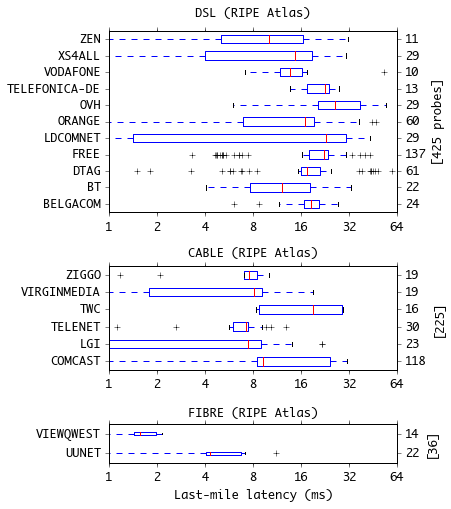

In [110]:
fig = plt.figure(figsize=(5,8))
fs = 12
plt.rcParams['font.size'] = fs

gs = gridspec.GridSpec(3,1, width_ratios=[1], height_ratios=[7, 4, 1.5])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

a = df_dsl.boxplot (  column='lastmile_median'
                    , by=['nodename']
                    , ax=ax1
                    , vert=False
                 )

stop_plot_box(a, chosen='DSL', count=dsl_count, probes_by_asn = dsl_probes_by_asn, fs = 12)

b = df_cable.boxplot (  column='lastmile_median'
                      , by=['nodename']
                      , ax=ax2
                      , vert=False
                     )

stop_plot_box(b, chosen='CABLE', count=cable_count, probes_by_asn = cable_probes_by_asn, shrink_right = True, fs = 12)

c = df_fibre.boxplot (  column='lastmile_median'
                      , by=['nodename']
                      , ax=ax3
                      , vert=False
                     )

stop_plot_box(c, chosen='FIBRE', count=fibre_count, probes_by_asn = fibre_probes_by_asn, shrink_right = True, fs = 12)

ax1.set_xlabel('', fontsize=fs)
ax2.set_xlabel('', fontsize=fs)

xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(xticklabels, visible=True)

fig.subplots_adjust(hspace = 0.5)

plt.savefig('ripeatlas-lastmile-latency-boxplot.pdf', format='pdf', bbox_inches='tight')

In [111]:
d = {  'FREE'          :    'FR'
     , 'COMCAST'       :    'US'
     , 'DTAG'          :    'DE'
     , 'ORANGE'        :    'FR'
     , 'TELENET'       :    'BE'
     , 'XS4ALL'        :    'NL'
     , 'OVH'           :    'FR'
     , 'LDCOMNET'      :    'FR'
     , 'BELGACOM'      :    'BE'
     , 'UUNET'         :    'US'
     , 'BT'            :    'UK'
     , 'LGI'           :    'EU'
     , 'VIRGINMEDIA'   :    'UK'
     , 'ZIGGO'         :    'NL'
     , 'TWC'           :    'US'
     , 'VIEWQWEST'     :    'SG'
     , 'TELEFONICA-DE' :    'DE'
     , 'ZEN'           :    'UK'
     , 'VODAFONE'      :    'DE'
    }